# Data Science Internship Assignment  
## Analysis of Trader Behavior vs Market Sentiment



## 1. Introduction

In this notebook, we analyze the relationship between Bitcoin market sentiment
(Fear & Greed Index) and trader behavior using historical trading data
from Hyperliquid.

The objective is to understand how profitability, leverage, and trading
activity change under different market sentiments.


## 2. Datasets

### 2.1 Bitcoin Fear & Greed Index
- Date
- Classification (Fear / Greed)

### 2.2 Hyperliquid Trader Data
- account
- symbol
- execution price
- size
- side
- time
- closedPnL
- leverage

## 3. Data Loading


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
fear_greed_df = pd.read_csv('fear_greed_index.csv')
trades_df = pd.read_csv('historical_data.csv')


In [14]:
fear_greed_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [15]:
trades_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [16]:
fear_greed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [17]:
fear_greed_df.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [18]:
fear_greed_df['classification'].value_counts()


,count
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326


In [19]:
# Mapping for simplified classification
mapping = {
    'Fear': 'Fear',
    'Extreme Fear': 'Fear',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed',
    'Neutral': 'Neutral'
}

fear_greed_df['sentiment'] = fear_greed_df['classification'].map(mapping)
fear_greed_df['sentiment'].value_counts()


,count
sentiment,
Fear,1289
Greed,959
Neutral,396


In [20]:
trades_df.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [21]:
# Make column names lowercase, remove spaces
trades_df.columns = trades_df.columns.str.strip().str.lower().str.replace(' ', '_')
trades_df.columns


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

In [22]:
# Convert 'timestamp_ist' to datetime with correct format
trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp_ist'], format='%d-%m-%Y %H:%M')

# Extract date only
trades_df['date'] = trades_df['timestamp'].dt.date

# Check first few rows
trades_df[['timestamp_ist','timestamp','date']].head()


,timestamp_ist,timestamp,date
0,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
1,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
2,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
3,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
4,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02


In [23]:
# Convert to datetime safely
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'], dayfirst=True, errors='coerce')

# Drop rows where conversion failed (NaT)
fear_greed_df = fear_greed_df.dropna(subset=['date'])

# Extract only date
fear_greed_df['date'] = fear_greed_df['date'].dt.date

# Check
fear_greed_df[['date','classification','sentiment']].head(10)




,date,classification,sentiment
0,2018-01-02,Fear,Fear
1,2018-02-02,Extreme Fear,Fear
2,2018-03-02,Fear,Fear
3,2018-04-02,Extreme Fear,Fear
4,2018-05-02,Extreme Fear,Fear
5,2018-06-02,Extreme Fear,Fear
6,2018-07-02,Fear,Fear
7,2018-08-02,Fear,Fear
8,2018-09-02,Fear,Fear
9,2018-10-02,Neutral,Neutral


In [24]:
fear_greed_df = fear_greed_df.copy()


In [25]:
# Merge trades with sentiment on 'date'
merged_df = trades_df.merge(
    fear_greed_df[['date', 'sentiment']],
    on='date',
    how='left'
)

# Check first 10 rows
merged_df[['date','sentiment']].head(10)


,date,sentiment
0,2024-12-02,Greed
1,2024-12-02,Greed
2,2024-12-02,Greed
3,2024-12-02,Greed
4,2024-12-02,Greed
5,2024-12-02,Greed
6,2024-12-02,Greed
7,2024-12-02,Greed
8,2024-12-02,Greed
9,2024-12-02,Greed


In [26]:
# Check how many missing sentiments
merged_df['sentiment'].isnull().sum()


np.int64(3972)

In [27]:
import numpy as np

x = np.int64(175360)
print(x)        # 175360
print(type(x))  # <class 'numpy.int64'>


175360
<class 'numpy.int64'>


In [28]:
# Group by sentiment (without leverage)
sentiment_summary = merged_df.groupby('sentiment').agg(
    total_trades=('closed_pnl', 'count'),
    average_pnl=('closed_pnl', 'mean'),
    total_volume=('size_tokens', 'sum')
).reset_index()

sentiment_summary


,sentiment,total_trades,average_pnl,total_volume
0,Fear,316,624.351062,4.326713e+05
1,Greed,363,57.646042,1.094550e+06
2,Neutral,8,0.000000,9.000000e+02


/tmp/ipython-input-924131190.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_summary, x='sentiment', y='average_pnl', palette='coolwarm')


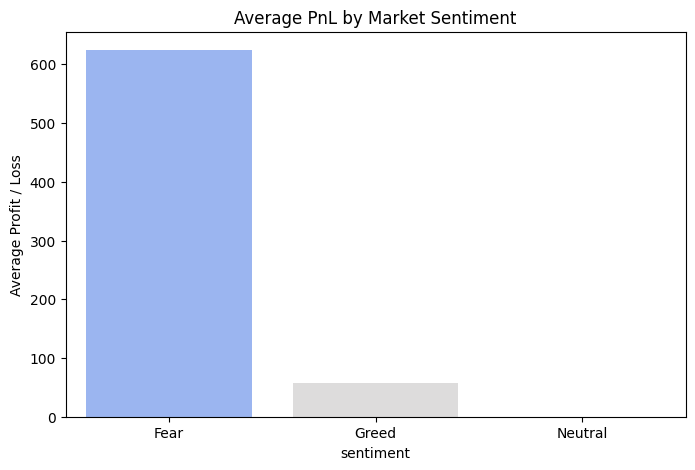

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_summary, x='sentiment', y='average_pnl', palette='coolwarm')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average Profit / Loss')
plt.show()


/tmp/ipython-input-2539483939.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_summary, x='sentiment', y='total_volume', palette='magma')


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/total_volume.png'

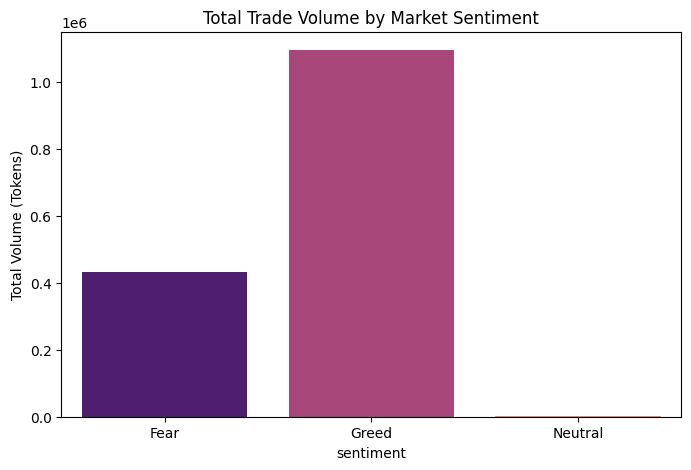

In [30]:
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_summary, x='sentiment', y='total_volume', palette='magma')
plt.title('Total Trade Volume by Market Sentiment')
plt.ylabel('Total Volume (Tokens)')
plt.savefig('outputs/total_volume.png')
plt.show()


In [31]:
import os

# folder banao agar nahi hai
os.makedirs('csv_files', exist_ok=True)

# merged data save karo
merged_df.to_csv('csv_files/merged_trades.csv', index=False)


In [32]:
sentiment_summary.to_csv('csv_files/sentiment_summary.csv', index=False)


In [33]:
import os

os.makedirs('outputs', exist_ok=True)


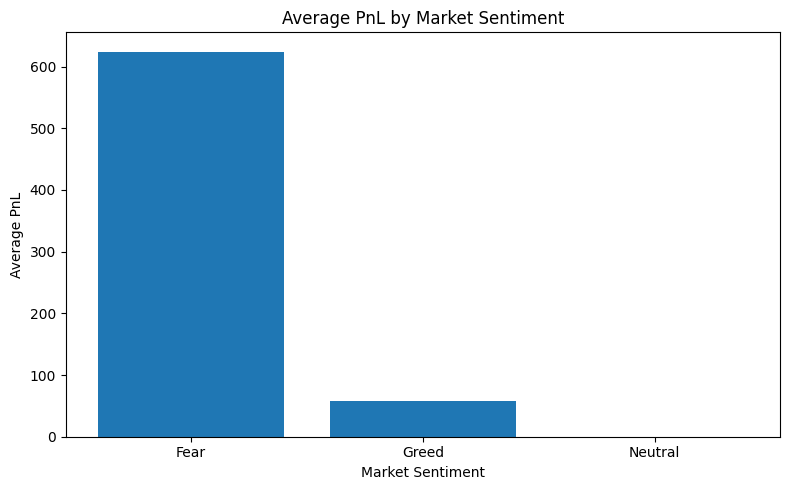

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(sentiment_summary['sentiment'], sentiment_summary['average_pnl'])
plt.title('Average PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average PnL')
plt.tight_layout()

# save image
plt.savefig('outputs/average_pnl.png')
plt.show()


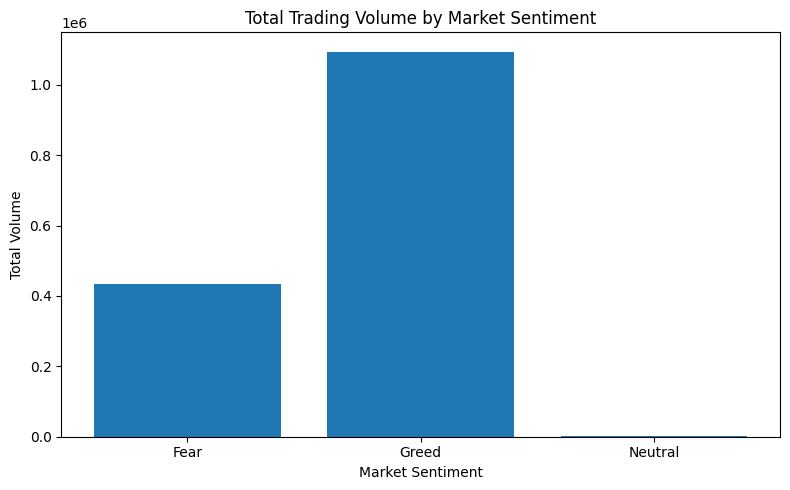

In [35]:
plt.figure(figsize=(8,5))
plt.bar(sentiment_summary['sentiment'], sentiment_summary['total_volume'])
plt.title('Total Trading Volume by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Volume')
plt.tight_layout()

# save image
plt.savefig('outputs/total_volume.png')
plt.show()
